# 5.3.Custom_Model_gray

In [ ]:
#!pip install sklearn
#!pip install imutils

In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, BatchNormalization, Dense, Dropout, Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from imutils import paths

from sklearn.preprocessing import LabelBinarizer, LabelEncoder

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Carga de los datos para el entrenamiento

In [3]:
img_size = 224
batch_size = 32
epochs = 10
path_checkpoints = 'checkpoint_VGG19'

path_train = 'data_' + str(img_size) + '/train'
path_validation = 'data_' + str(img_size) + '/validation'

In [4]:
imagePaths_train = list(paths.list_images(path_train))
imagePaths_validation = list(paths.list_images(path_validation))
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths_train]
classNames = [str(x) for x in np.unique(classNames)]

print("etiquetas del entrenamiento")
print(classNames)

#Códificando las etiquetas en númerops
print("codificando etiquetas")
le = LabelEncoder()
classNames_ids = le.fit_transform(classNames)
print(classNames_ids)

etiquetas del entrenamiento
['100_espalda', '100_frente', '10_espalda', '10_frente', '200_espalda', '200_frente', '20_espalda', '20_frente', '50_espalda', '50_frente']
codificando etiquetas
[0 1 2 3 4 5 6 7 8 9]


In [5]:
aug_train = ImageDataGenerator(rescale=1. / 255,
                               featurewise_std_normalization=True,
                               samplewise_std_normalization=True)
#aug_train.fit(data_train)
train_generator = aug_train.flow_from_directory(path_train,
                                                color_mode='grayscale',
                                                target_size=(img_size, img_size),
                                                batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 3360 images belonging to 10 classes.


In [6]:
aug_validation = ImageDataGenerator(rescale=1. / 255)
#aug_validation.fit(data_validation)
validation_generator = aug_validation.flow_from_directory(path_validation,
                                                color_mode='grayscale',
                                                          target_size=(img_size, img_size),
                                                          batch_size=batch_size)

Found 2671 images belonging to 10 classes.


# Creamos el modelo tipo VGG19

In [7]:
model = Sequential()

#model.add(BatchNormalization(input_shape=(img_size, img_size, 1))),

model.add(Conv2D(96, kernel_size=(7, 7), activation='relu', input_shape=(img_size, img_size, 1))) #218
model.add(MaxPooling2D((3,3), strides=(2,2))) #108

model.add(Conv2D(128, kernel_size=(5, 5), activation='relu')) #104
model.add(MaxPooling2D((3,3), strides=(2,2))) #51

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu')) #49
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu')) #47

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu')) #45
model.add(MaxPooling2D((3,3), strides=(2,2))) #22


model.add(Flatten()),
model.add(Dense(4096, activation='relu'))
model.add(Dense(2048, activation='relu'))

model.add(Dense(len(classNames), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 218, 218, 96)      4800      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 108, 108, 96)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 104, 104, 128)     307328    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 51, 51, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 49, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 47, 47, 256)       590080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 45, 45, 128)       2

## Compilamos el modelo

In [11]:
#default learning_rate = 0.001
optimizer = SGD(learning_rate=0.0001)
#optimizer = Adam(learning_rate=0.01)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

model.compile(optimizer=optimizer, 
              loss=loss, 
              metrics=metrics)

In [12]:
fname = os.path.sep.join([path_checkpoints, 
                          'epoch-{epoch:03d}-val_loss:{val_loss:.4f}-val_accuracy:{val_accuracy:.4f}.hdf5'])
checkpoint = ModelCheckpoint(fname,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)
#callbacks = [checkpoint]
callbacks = []

In [13]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              validation_data=validation_generator,
                              epochs = epochs,
                              callbacks=callbacks,
                              verbose = 1)

Epoch 1/10
105/105 [==============================] - 50s 475ms/step - loss: 2.3011 - accuracy: 0.1107 - val_loss: 2.3076 - val_accuracy: 0.1060
Epoch 2/10
105/105 [==============================] - 50s 472ms/step - loss: 2.3011 - accuracy: 0.1107 - val_loss: 2.3076 - val_accuracy: 0.1060
Epoch 3/10
105/105 [==============================] - 50s 477ms/step - loss: 2.3011 - accuracy: 0.1107 - val_loss: 2.3076 - val_accuracy: 0.1060
Epoch 4/10
105/105 [==============================] - 50s 476ms/step - loss: 2.3011 - accuracy: 0.1107 - val_loss: 2.3076 - val_accuracy: 0.1060
Epoch 5/10
105/105 [==============================] - 50s 477ms/step - loss: 2.3011 - accuracy: 0.1107 - val_loss: 2.3076 - val_accuracy: 0.1060
Epoch 6/10
105/105 [==============================] - 50s 476ms/step - loss: 2.3011 - accuracy: 0.1107 - val_loss: 2.3076 - val_accuracy: 0.1060
Epoch 7/10
105/105 [==============================] - 50s 475ms/step - loss: 2.3011 - accuracy: 0.1107 - val_loss: 2.3075 - val_ac

## Creando un gráfico para la revisión

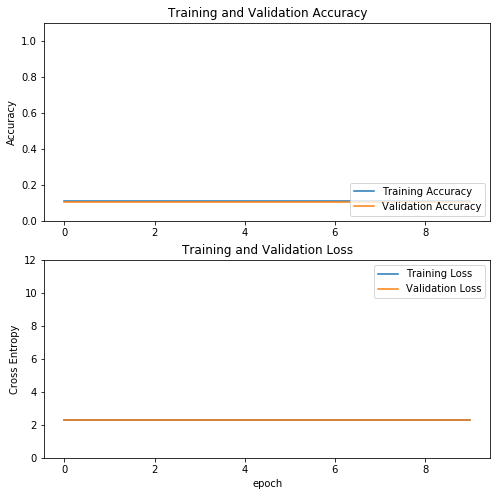

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.ylim([0,12])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Guardando el modelo

In [ ]:
saved_model_dir = 'model'
tf.saved_model.save(model, saved_model_dir)

## Convirtiendo el modelo en tensorflow lite para el uso en mobile

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

path_tensorflow_lite = 'model_tflite/vgg19_model.tflite'
with open(path_tensorflow_lite, 'wb') as f:
  f.write(tflite_model)

# Tomando 25 imágenes de validación y observando el resultado

In [15]:
aug_validation = ImageDataGenerator(rescale=1. / 255)
#aug_validation.fit(data_validation)
test_data = ImageDataGenerator(rescale=1. / 255).flow_from_directory(path_validation,
                                                color_mode='grayscale',
                                                          target_size=(img_size, img_size),
                                                          batch_size=batch_size)

test_data = ImageClassifierDataLoader.from_folder(path_validation)

def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(test_data.dataset.take(100)):
    ax = plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)
    
    # predict
    swapped = np.moveaxis(image, 0, 1)
    arr4d = np.expand_dims(swapped, 0)
    id_predict = np.argmax(model.predict(arr4d))
    predict_label = classNames[id_predict]
    
    color = get_label_color(predict_label, test_data.index_to_label[label.numpy()])
    #color = 'black'
    ax.xaxis.label.set_color(color)
    plt.xlabel('Predicted: %s' % predict_label)
plt.show()

NameError: name 'ImageClassifierDataLoader' is not defined